# Object Size, Shape & Intensity

This notebook shows you (1) how to determine the size of either a single object or all of the objects in an instance segmentation dataset, (2) how to index the dictionaries that are the output of `skimage.regionprops` and (3) shows some of the 'underbelly' workings of `regionprops` by first showing you how to implement `scipy.ndimage.labeled_comprehension` and then showing you how to write an intensity standard deviation function yourself.

In [1]:
from __future__ import division, print_function

import numpy as np
from skimage.io import imread, imshow
from skimage.measure import regionprops
from scipy.ndimage import labeled_comprehension
import matplotlib.pyplot as plt

%matplotlib inline

# Load Data

We will use an instance segmentation that is the result of a voronoi otsu labeling method applied to a small crop of the `skimage.data.cells3d()`.

/Users/ryan/mambaforge/envs/devbio-napari-env/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


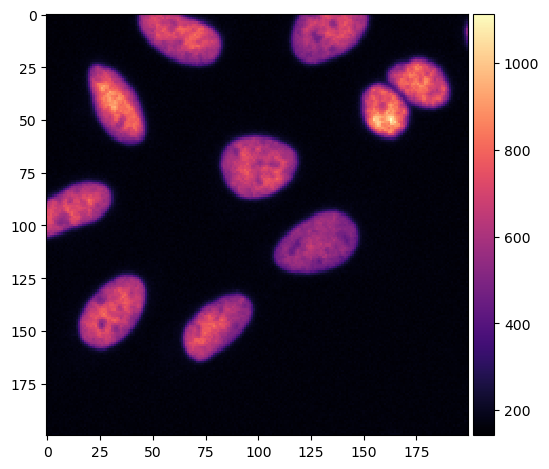

In [2]:
input_image = imread('data/cropped_raw_image.tif')
imshow(input_image, cmap='magma')

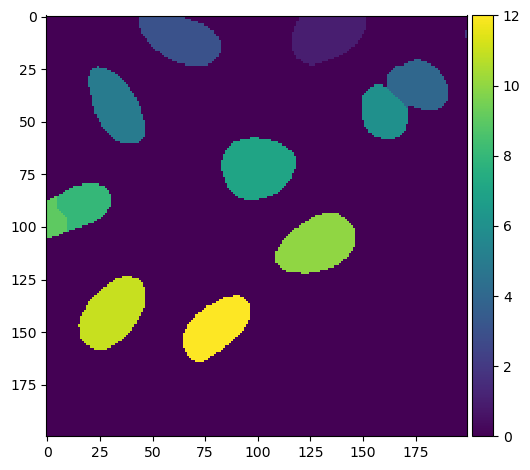

In [3]:
voronoi_otsu_segmentation = imread('data/instance_segmentation.tif')
imshow(voronoi_otsu_segmentation)

# Extract Features

Apply `regionprops` from `skimage.measure` to the labeled image. This will return a list of dictionaries. Each dictionary corresponds to a single object (i.e., nucleus) in the labeled image. Below I show you how to index each dictionary with a key to retrieve a specific feature (i.e., eccentricity) that is measured by `regionprops`. 

In [4]:
regprops = regionprops(voronoi_otsu_segmentation)

In [5]:
for i in range(len(regprops)):
    print(regprops[i].eccentricity)

0.7903767216752334
1.0
0.8591188380687891
0.6774692528388002
0.8682019435379323
0.637161426772526
0.5656238837964573
0.6409503067624858
0.8470599794547478
0.780930799306185
0.8003925438834633
0.8451613028758732


# Colorcode your image by feature measurements

In the following cell, I show you how to create an image where the colormap values correspond to a chosen feature value using python indexing tricks. 

This can be very useful for creating visuals for presentations to be shown in parallel with plots or other quantification visuals.

In [6]:
eccentricity_image = np.copy(voronoi_otsu_segmentation).astype(float)
for i in range(len(regprops)):
    eccentricity_image[eccentricity_image == i+1] = regprops[i].axis_minor_length / regprops[i].axis_major_length

You can save the image you just created either as a '.tif' file using `skimage.io.imsave` or simply by displaying it as an image plot using `skimage.io.imshow` followed by `plt.savefig`. If you use the second approach, be sure to define an appropriate resolution (i.e., dpi) for presentations/figures.

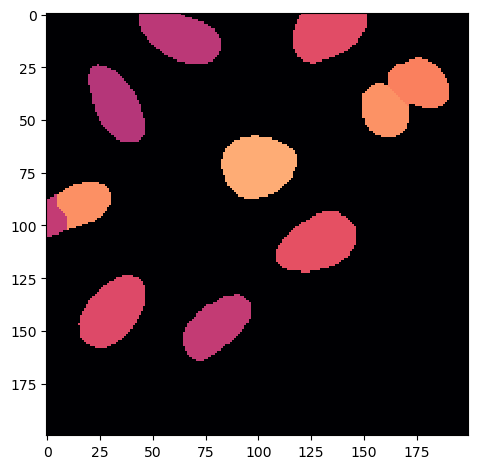

In [7]:
imshow(eccentricity_image, cmap = 'magma')
plt.tight_layout()
plt.savefig('eccentricity_image.png', dpi = 300)

# Mean Intensity

We will use the segmentation result to calculate the mean intensity of one object in the orginal image. We will look at the object with the segmention label ID $8$. To do this, we will use a neat indexing trick.

In [8]:
mean_intenstity = np.mean(input_image[voronoi_otsu_segmentation == 8])
mean_intenstity

614.1990291262136

# Minimum & Maximum Intensities

This time assign the index that we used for the mean intensity to a variable so that we can use it to calculate the object's minimum and maximum intensities in the same fashion.

In [9]:
mask = input_image[voronoi_otsu_segmentation == 8]

In [10]:
minimum_intensity = np.min(mask)
minimum_intensity

386

In [11]:
maximum_intensity = np.max(mask)
maximum_intensity

821

In the following cell, retrieve the minimum and maximum intensity of each of the labeled objects from `regprops` using the correct keys for the dictionaries (if you do not know them, either check the function's docstring by clicking 'shift tab' inside the round parentheses or go to the skimage.measure API (<https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops>).

# Labeled Comprehension

We can use a function from the `scipy.ndimage` library called `labeled_comprehension` if you wish to only run one function that measures a feature, here `np.mean` to retrieve the mean pixel intensity, for all objects in an instance segmentation. `labeled_comprehension` requires many inputs so read the docstring and carefully think about the correct data to pass.

In [12]:
labels = np.unique(voronoi_otsu_segmentation) # this function finds all of the values present in an array
labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=uint8)

In [13]:
labels = labels[labels > 0] # index out background value(s)
labels

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=uint8)

In [14]:
mean_intensities = labeled_comprehension(input_image, 
                                         voronoi_otsu_segmentation, 
                                         labels, 
                                         np.mean,
                                         int, 
                                         0)

# Object Size

Here we want calculate the size, in pixels, of each object in an instance segmentation. To do this using `labeled_comprehension` we need to use a boolean image instead of the input image. 

Once we have areas in terms of pixel counts, we can then convert them to $\mu$m$^2$ if we know the $x$ and $y$ resolutions from the microscope (I have chosen the resolution randomly).

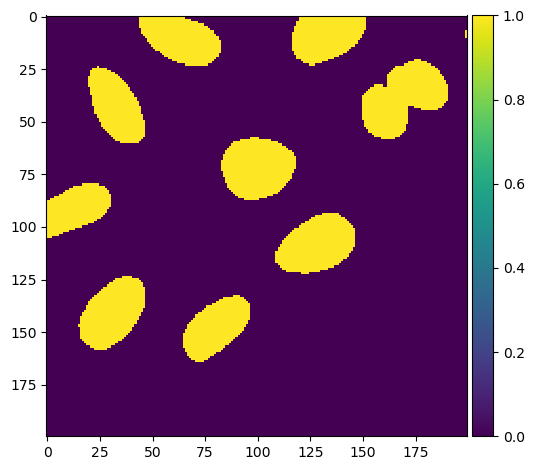

In [15]:
boolean_image = voronoi_otsu_segmentation.astype(bool)
imshow(boolean_image.astype(int))

In the next cell, we again use `labeled_comprehension` to apply a single function to each labeled object. Subsequent cells show how you can rescale from pixel areas (i.e., counts) to $\mu$m$^2$ area measurements.

In [16]:
pixel_areas = labeled_comprehension(boolean_image, 
                                    voronoi_otsu_segmentation, 
                                    labels, 
                                    np.sum, 
                                    int, 
                                    0)
pixel_areas

array([652,   4, 684, 521, 655, 440, 824, 412, 141, 792, 758, 645])

In [17]:
x_resolution = 0.2
y_resolution = 0.2

unit_pixel = x_resolution * y_resolution
unit_pixel

0.04000000000000001

In [18]:
square_micrometer_area = pixel_areas * unit_pixel
square_micrometer_area

array([26.08,  0.16, 27.36, 20.84, 26.2 , 17.6 , 32.96, 16.48,  5.64,
       31.68, 30.32, 25.8 ])

We can again create an image where the colormap reflects the measured feature ($\mu$m$^2$ area).

/Users/ryan/mambaforge/envs/devbio-napari-env/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


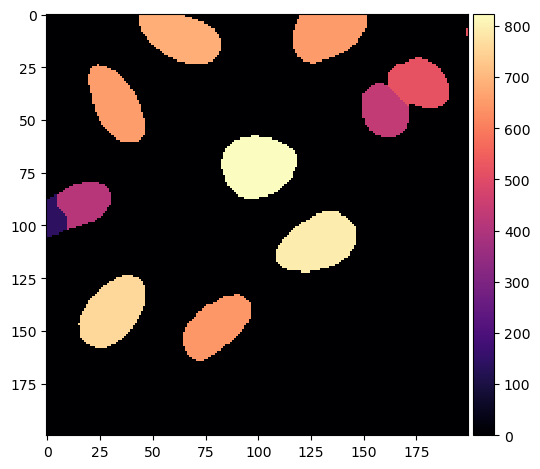

In [19]:
area_image = np.copy(voronoi_otsu_segmentation).astype(float)
for i in labels:
    area_image[area_image == i] = pixel_areas[i-1]
imshow(area_image, cmap = 'magma')

# Plotting Your Features

Before diving into statistical analysis, sometimes it is good to plot the values of your features as a histogram or scatter plot as a sanity check to ensure that you did not somehow impart bias into your analysis. 

Below we will plot two of the features we extracted as histograms and then as a scatter plot comparing them. These plots are very simple, but if you would like to customize the axes, colors, etc. look at the following documentation:


<https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html>

<https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html>

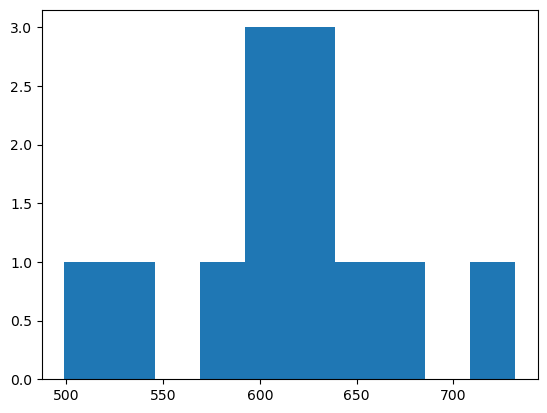

In [20]:
plt.hist(mean_intensities)
plt.show()

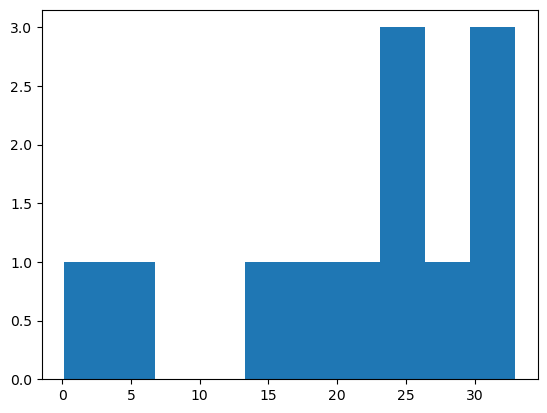

In [21]:
plt.hist(square_micrometer_area)
plt.show()

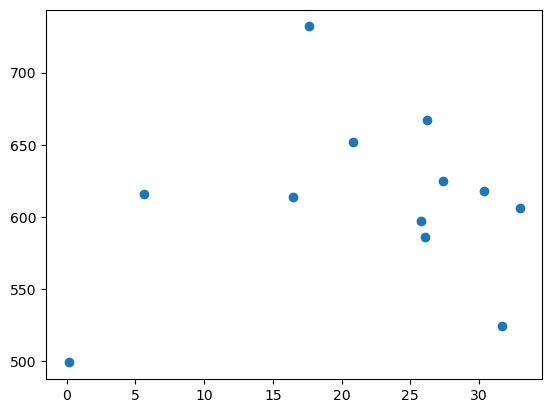

In [22]:
plt.scatter(square_micrometer_area, mean_intensities)
plt.show()

# Exercise

To better understand the 'inner workings' of `regionprops` and/or `labeled_comprehension` works', write a function using a for loop, `np.unique` and `np.std` to retrieve the standard deviation of intensity values for each object in the image used above. Then apply your function, plot a histogram of its results and compare it to the results of from `regionprops` and/or `labeled_comprehension`.

In [23]:
def object_standard_deviation(input_image, segmented_image):
    
    from numpy import unique, zeros_like, std
    
    labels = unique(segmented_image)
    labels = labels[labels > 0]
    
    stds = zeros_like(labels, dtype=float)
    
    counter = 0
    for i in labels:
        i_mask = input_image[segmented_image == i]
        i_std = std(i_mask)
        stds[counter] = i_std
        counter += 1
    
    return stds

In [24]:
stds = object_standard_deviation(input_image, voronoi_otsu_segmentation)
stds

array([ 84.36602844,  21.45198126,  95.63218092, 132.03439707,
       139.25476677, 153.20006971,  81.87191519,  87.66097093,
        86.30787008,  53.90184463,  91.3030485 ,  98.35668465])

In [25]:
lc_stds = labeled_comprehension(input_image, voronoi_otsu_segmentation, labels, np.std, out_dtype=float, default=0)
lc_stds

array([ 84.36602844,  21.45198126,  95.63218092, 132.03439707,
       139.25476677, 153.20006971,  81.87191519,  87.66097093,
        86.30787008,  53.90184463,  91.3030485 ,  98.35668465])